In [1]:
import os
import sys
import warnings

import pickle
import pandas as pd
import numpy as np
import re
import string
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('datasets/amazon.csv')
df.head()

,reviewText,Positive
0,This is a one of the best apps acording to a b...,1
1,This is a pretty good version of the game for ...,1
2,this is a really cool game. there are a bunch ...,1
3,"This is a silly game and can be frustrating, b...",1
4,This is a terrific game on any pad. Hrs of fun...,1


In [3]:
df.isnull().sum()

reviewText    0
Positive      0
dtype: int64

In [4]:
df.dtypes

reviewText    object
Positive       int64
dtype: object

In [5]:
df.shape

(20000, 2)

In [6]:
df['Positive'].value_counts()

Positive
1    15233
0     4767
Name: count, dtype: int64

# Class Visualization

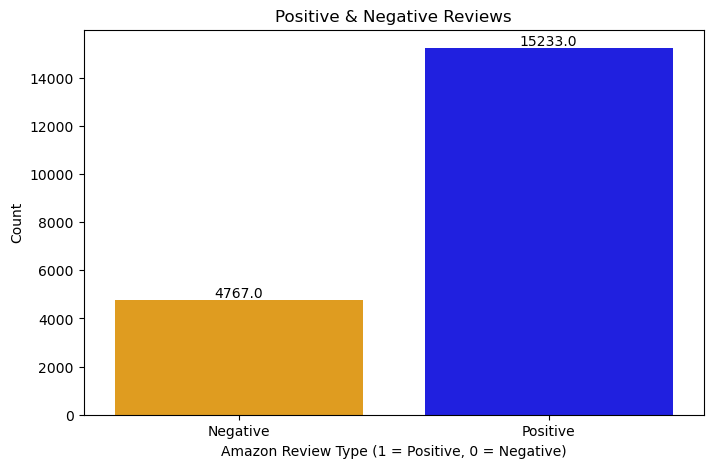

In [7]:
plt.figure(figsize=(8, 5))
axis = sns.countplot(x=df['Positive'], palette=['orange', 'blue'])

plt.xlabel("Amazon Review Type (1 = Positive, 0 = Negative)")
plt.ylabel("Count")
plt.title("Positive & Negative Reviews")

# Add labels above bars
for i in axis.patches:
    axis.annotate(f'{i.get_height()}',
                  (i.get_x() + i.get_width()/2, i.get_height()),
                  ha='center', va='bottom')

plt.xticks([0, 1], ["Negative", "Positive"])
plt.show()


# Preprocessing

In [8]:
def lower_case(text):
    return text.lower()

In [9]:
df.reviewText = df.reviewText.apply(lower_case)

In [10]:
df.head()

,reviewText,Positive
0,this is a one of the best apps acording to a b...,1
1,this is a pretty good version of the game for ...,1
2,this is a really cool game. there are a bunch ...,1
3,"this is a silly game and can be frustrating, b...",1
4,this is a terrific game on any pad. hrs of fun...,1


In [11]:
def clean_unique(text):
    regex_unique = re.compile('[^\w\s]')
    clean_unique = re.sub(regex_unique, " ", text).strip()
    return re.sub(r"\s+", " ", clean_unique).strip()

In [12]:
df = df.sort_values(by=['reviewText', 'Positive'], ascending=True)
df_sample_text = df['reviewText'][26]
df_sample_text_clean = clean_unique(df_sample_text)
print(df_sample_text)
print(df_sample_text_clean)

this is the game124 to get. those other bad comments r stupid. this app doesn't need wifi.  i like this app a lot its free and who doesn't love angry birds!!!
this is the game124 to get those other bad comments r stupid this app doesn t need wifi i like this app a lot its free and who doesn t love angry birds


In [13]:
df.reviewText = df.reviewText.apply(clean_unique)

In [14]:
df.reviewText[22]

'this is the best game they could think of i downloaded it and my fav character is the original pig yay love it'

In [15]:
df_sample_text

"this is the game124 to get. those other bad comments r stupid. this app doesn't need wifi.  i like this app a lot its free and who doesn't love angry birds!!!"

In [16]:
def clean_stop_word(text):
    stop_word = stopwords.words('english')
    filter_without_stopwords = []

    for i in text.split():
        if i not in stop_word:
            filter_without_stopwords.append(i)

    return filter_without_stopwords

In [17]:
df.reviewText = df.reviewText.apply(clean_stop_word)

In [18]:
df.head()

,reviewText,Positive
6573,"[calculator, ultimate, outstanding, calculator...",1
17399,"[circlelauncher, clever, app, allows, one, ico...",1
6701,"[comiccat, first, last, comic, book, app, look...",1
14001,"[drawing, pad, exactly, drawing, app, kindle, ...",1
10262,"[farkle, fun, almost, addictive, dice, game, p...",1


In [19]:
df_test = df.copy()

In [20]:
df_smaple_test = df_test.reviewText[26]
df_smaple_test

['game124',
 'get',
 'bad',
 'comments',
 'r',
 'stupid',
 'app',
 'need',
 'wifi',
 'like',
 'app',
 'lot',
 'free',
 'love',
 'angry',
 'birds']

In [21]:
def stemming(text):
    p_stemmer = PorterStemmer()
    stemmed_word = []

    for i in text:
        stemmed_word.append(p_stemmer.stem(i))

    return stemmed_word

In [22]:
def lemmatizing(text):
    lemmatize = WordNetLemmatizer()
    lemmatized_word = []

    for i in text:
        lemmatized_word.append(lemmatize.lemmatize(i))
    
    return lemmatized_word

In [23]:
df.reviewText = df.reviewText.apply(lemmatizing)

In [24]:
print(lemmatizing(df_smaple_test))

['game124', 'get', 'bad', 'comment', 'r', 'stupid', 'app', 'need', 'wifi', 'like', 'app', 'lot', 'free', 'love', 'angry', 'bird']


In [25]:
df.head()

,reviewText,Positive
6573,"[calculator, ultimate, outstanding, calculator...",1
17399,"[circlelauncher, clever, app, allows, one, ico...",1
6701,"[comiccat, first, last, comic, book, app, look...",1
14001,"[drawing, pad, exactly, drawing, app, kindle, ...",1
10262,"[farkle, fun, almost, addictive, dice, game, p...",1


In [26]:
def join_back(text):
    joined_word = " ".join(text)
    return joined_word

In [27]:
df.reviewText = df.reviewText.apply(join_back)

In [28]:
df.head()

,reviewText,Positive
6573,calculator ultimate outstanding calculator app...,1
17399,circlelauncher clever app allows one icon home...,1
6701,comiccat first last comic book app looking way...,1
14001,drawing pad exactly drawing app kindle fire ea...,1
10262,farkle fun almost addictive dice game played c...,1


In [29]:
# count_vectorize = CountVectorizer(max_features=4000)
# X_feature = count_vectorize.fit_transform(df.reviewText).toarray()

In [30]:
tfidf_vectorize = TfidfVectorizer(max_features=4000, ngram_range=(1,2))
X_feature = tfidf_vectorize.fit_transform(df.reviewText).toarray()

In [31]:
pd.DataFrame(X_feature)

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
y = df.Positive

In [33]:
X_feature.shape

(20000, 4000)

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X_feature, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=2)

In [35]:
print(f'shape xFeature : {X_feature.shape}')
print(f'shape x train : {x_train.shape}')
print(f'shape x test : {x_test.shape}')
print(f'shape y train : {y_train.shape}')
print(f'shape y test : {y_test.shape}')

shape xFeature : (20000, 4000)
shape x train : (16000, 4000)
shape x test : (4000, 4000)
shape y train : (16000,)
shape y test : (4000,)


In [36]:
# gaussian_model = GaussianNB()
# bernouli_model = BernoulliNB()
# multinomial_model = MultinomialNB()

In [37]:
class Utils:
    tag_accuracy = "Accuracy Score - "
    test_split_tag = "Test Split"
    train_split_tag = "Train Split"
    matrics_label = "Accuracy Score",
    model_name_multinomial = 'Multinomial Naive Bayes',
    model_name_gaussian = "Gaussian Naive Bayes",
    model_name_bernoulli = "Bernoulli Naive Bayes",
    underline = 60*'-'

In [38]:
class Model:
    gaussian_model = GaussianNB()
    bernouli_model = BernoulliNB()
    multinomial_model = MultinomialNB()

In [39]:
def train_and_test(x, y):
    model = Model()
    model.gaussian_model.fit(x, y)
    model.bernouli_model.fit(x, y)
    model.multinomial_model.fit(x, y)
    return model

In [40]:
trained_model = train_and_test(x_train, y_train)
trained_model

In [41]:
test_model = train_and_test(x_test, y_test)
test_model

In [42]:
model = Model()
ypred_training_gaussian = model.gaussian_model.predict(x_train)
ypred_training_bernouli = model.bernouli_model.predict(x_train)
ypred_training_multinomial = model.multinomial_model.predict(x_train)

In [43]:
model = Model()
ypred_testing_gaussian = model.gaussian_model.predict(x_test)
ypred_testing_bernouli = model.bernouli_model.predict(x_test)
ypred_testing_multinomial = model.multinomial_model.predict(x_test)

# Model Evaluation

In [44]:
utils = Utils()

score_gaussian_train = accuracy_score(y_train, ypred_training_gaussian)
score_bernouli_train = accuracy_score(y_train, ypred_training_bernouli)
score_multinomial_train = accuracy_score(y_train, ypred_training_multinomial)

print(f'{utils.matrics_label}')
print(f'{utils.underline}')
print(f'{utils.tag_accuracy}{utils.train_split_tag} Gaussian NB : {score_gaussian_train}')
print(f'{utils.tag_accuracy}{utils.train_split_tag} Bernouli NB : {score_bernouli_train}')
print(f'{utils.tag_accuracy}{utils.train_split_tag} Multinomial NB : {score_multinomial_train}')


('Accuracy Score',)
------------------------------------------------------------
Accuracy Score - Train Split Gaussian NB : 0.7711875
Accuracy Score - Train Split Bernouli NB : 0.87
Accuracy Score - Train Split Multinomial NB : 0.8318125


In [45]:
utils = Utils()

score_gaussian_test = accuracy_score(y_test, ypred_testing_gaussian)
score_bernouli_test = accuracy_score(y_test, ypred_testing_bernouli)
score_multinomial_test = accuracy_score(y_test, ypred_testing_multinomial)

print(f'{utils.matrics_label}')
print(f'{utils.underline}')
print(f'{utils.tag_accuracy}{utils.test_split_tag} Gaussian NB : {score_gaussian_test}')
print(f'{utils.tag_accuracy}{utils.test_split_tag} Bernouli NB : {score_bernouli_test}')
print(f'{utils.tag_accuracy}{utils.test_split_tag} Multinomial NB : {score_multinomial_test}')


('Accuracy Score',)
------------------------------------------------------------
Accuracy Score - Test Split Gaussian NB : 0.903
Accuracy Score - Test Split Bernouli NB : 0.92925
Accuracy Score - Test Split Multinomial NB : 0.86875


In [46]:
# Confusion Matrix graph
def plot_confusion(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Predicted 1', 'Predicted 0'],
        yticklabels=['Actual 1', 'Actual 0']
    )
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

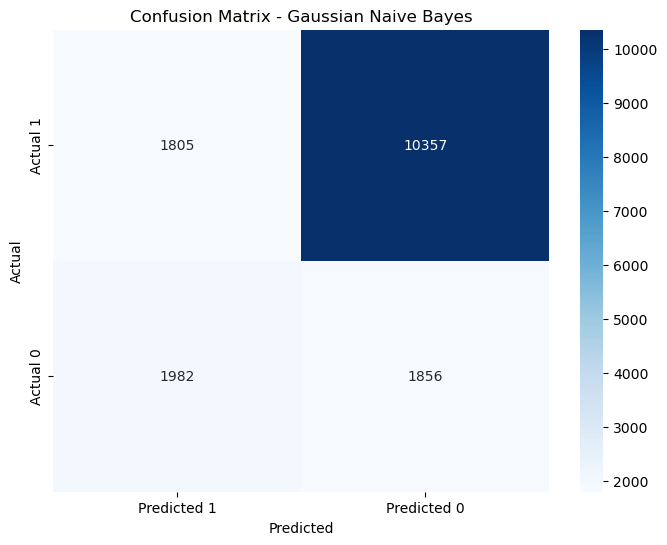

In [ ]:
cm_gaussian = confusion_matrix(y_train, ypred_training_gaussian)
cm_flip = cm_gaussian[::-1]
plot_confusion(cm_flip, 'Confusion Matrix - Gaussian Naive Bayes')


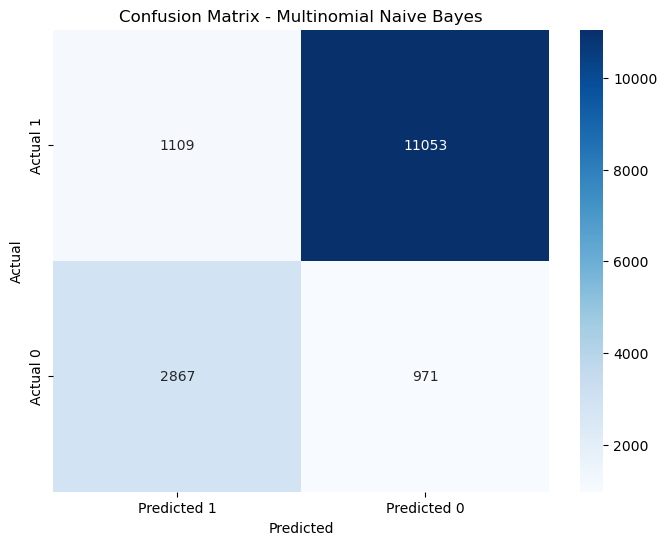

In [57]:
cm_multinomial = confusion_matrix(y_train, ypred_training_bernouli)
cm_flip = cm_multinomial[::-1]
plot_confusion(cm_flip, 'Confusion Matrix - Multinomial Naive Bayes')


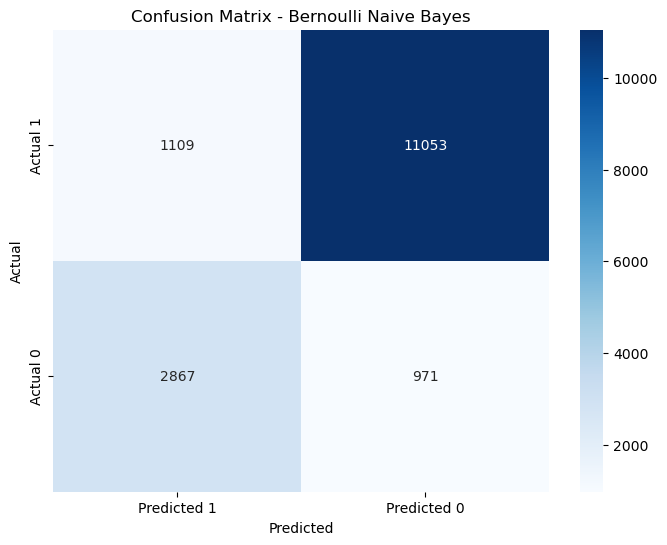

In [58]:
cm_bernoulli = confusion_matrix(y_train, ypred_training_bernouli)
cm_flip = cm_bernoulli[::-1]
plot_confusion(cm_flip, 'Confusion Matrix - Bernoulli Naive Bayes')


In [50]:
print(classification_report(y_test, model.bernouli_model.predict(x_test), digits=3))

              precision    recall  f1-score   support

           0      0.837     0.863     0.850       929
           1      0.958     0.949     0.954      3071

    accuracy                          0.929      4000
   macro avg      0.898     0.906     0.902      4000
weighted avg      0.930     0.929     0.930      4000



In [51]:
print(classification_report(y_train, model.bernouli_model.predict(x_train), digits=3))

              precision    recall  f1-score   support

           0      0.721     0.747     0.734      3838
           1      0.919     0.909     0.914     12162

    accuracy                          0.870     16000
   macro avg      0.820     0.828     0.824     16000
weighted avg      0.872     0.870     0.871     16000



# Inference

In [ ]:
def inference(random_input):
    
    model = Model()
    
    # lower case conversion
    random_input.lower()

    # clean uniques
    regex_unique = re.compile('[^\w\s]')
    clean_unique = re.sub(regex_unique, " ", random_input).strip()

    # clean space
    clean_space = re.sub(r"\s+", " ", clean_unique).strip()

    # clean stop word
    stop_words = stopwords.words('english')
    filter_without_stopwords = []
    for i in clean_space.split():
        if i not in stop_words:
            filter_without_stopwords.append(i)

    # stemming 
    leammatize = WordNetLemmatizer()
    lemmatized_words = []
    for j in filter_without_stopwords:
        lemmatized_words.append(leammatize.lemmatize(j))

    # joining back 
    joined_word = " ".join(lemmatized_words)

    # vectorize word
    single_word_vectorize = tfidf_vectorize.transform([joined_word]).toarray()

    # Prediction
    y_pred = model.multinomial_model.predict(single_word_vectorize)[0]

    # prediction lebl
    label = ""
    if y_pred == 1:
        label = "Customer is very Positive :) about his/her review !"
    elif y_pred == 0:
        label = "Customer is very Negative :( about his/her review !"

    # Confidence level
    confidence = model.multinomial_model.predict_proba(single_word_vectorize)[0, 1]
    confidence_percentage = confidence * 100

    # Prediction results
    data = {
        'prediction': y_pred,
        'label': label,
        'confidence': confidence_percentage,
        'model_info': model.bernouli_model
    }

    return data


In [53]:
inference("I didn't like it at all .I think it is more for kids. I am really not into many games")

{'prediction': 1,
 'label': 'Customer is very Positive :) about his/her review !',
 'confidence': 89.27887775953056,
 'model_info': MultinomialNB()}

# Pickle

In [54]:
# Pickle Save
def save_pickle():

    with open ('bernoulli_naive_bayes_model.pkl', 'wb') as f:
        pickle.dump(model.bernouli_model, f)

    with open('tfidf_vectorizer.pkl', 'wb') as f:
        pickle.dump(tfidf_vectorize, f)

save_pickle()


In [55]:
# Pickle Load
with open("bernoulli_naive_bayes_model.pkl", "rb") as f:
    model = pickle.load(f)
    print(model)

with open("tfidf_vectorizer.pkl", "rb") as f:
    tfidf_vectorize = pickle.load(f)
    print(tfidf_vectorize)



BernoulliNB()
TfidfVectorizer(max_features=4000, ngram_range=(1, 2))
